# РАР вариант №4 на тему: "Надежность сети"

**Выполнил:** студент группы ЗБ-ПИ20-2 Петренко Артемий

## Условие
Дана сеть, ее подсеть, вероятности неисправности при проходе по каждому из ребер и надежность сети $q$. Узнать, верно ли, что для любых двух узлов подсети между ними существует путь с надежностью не меньшей чем $q$.

## Решение
Задача сводится к решению проблемы о поиске пути, при этом найденный путь должен обладать надежностью не меньше заданной. Соответственно параметр надежности становится весами ребер графа, которым мы будем представлять сеть. Для поиска пути существует множество разных алгоритмов, наиболее популярным и функциональным являтся алгоритм Дейкстры.

### Простая реализация алгоритма Дейкстры

In [ ]:
import numpy as np
import timeit

def serial_dijkstra(graph, start):
    n = graph.shape[0]
    distances = np.full(n, np.inf)
    distances[start] = 0
    visited = np.zeros(n)
    visited[start] = 1
    for i in range(n):
        if visited[i]:
            for j in range(n):
                if graph[i][j] and distances[j] > distances[i] + graph[i][j]:
                    distances[j] = distances[i] + graph[i][j]
                    visited[j] = 1
    return distances

def test_serial_dijkstra_gpu(graph,  start = 0):
    distance = serial_dijkstra(graph, start)
    return [graph.shape[0], np.count_nonzero(graph)//2]

def serial_execution_time(graph,  start = 0):
    time = timeit.timeit(lambda: test_serial_dijkstra_gpu(graph, start), number=1)
    return time

### Реализация с мультипроцессингом


!**Для выполнения кода представленного дальше необходимо переключить среду выполения на T4 GPU**

Оптимизация решения поставленной задачи сводится к переносу алгоритма Дейкстры на многопоточное выполнение с помощью CUDA ядер

In [ ]:
!nvidia-smi

Sun May 12 15:29:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install pycuda
!sudo find /usr/ -name 'libcuda.so.*'


/usr/local/cuda-12.2/compat/libcuda.so.1
/usr/local/cuda-12.2/compat/libcuda.so.535.129.03
/usr/lib64-nvidia/libcuda.so.535.104.05
/usr/lib64-nvidia/libcuda.so.1


In [ ]:
import numpy as np
import pycuda.gpuarray as gpuarray
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import timeit

# CUDA kernel для алгоритма Дейкстры
kernel = """
    __global__ void dijkstra(float *d, int *p, int *visited, int n, int start)
    {
        int i = threadIdx.x + blockIdx.x * blockDim.x;

        if(i < n)
        {
            if(visited[i] == 0)
            {
                int j;
                for(j = 0; j < n; j++)
                {
                    if(visited[j] == 1)
                    {
                        int weight = p[i*n + j];
                        if(weight != 0 && d[j] + weight < d[i])
                        {
                            d[i] = d[j] + weight;
                            visited[i] = 1;
                        }
                        else
                        {
                            visited[i] = 1;
                        }
                    }
                }
            }
        }
    }
"""

def parallel_dijkstra_gpu(graph, start):
    n = graph.shape[0]
    # Разложение весов матрицы в одномерный массив
    graph = graph.flatten()
    d = np.full(n, np.inf)
    d[start] = 0
    visited = np.zeros(n)
    visited[start] = 1

    # Выделение памяти для GPU
    d_gpu = gpuarray.to_gpu(d.astype(np.float32))
    p_gpu = gpuarray.to_gpu(graph.astype(np.int32))
    visited_gpu = gpuarray.to_gpu(visited.astype(np.int32))


    # компиляция CUDA ядра
    mod = SourceModule(kernel)
    func = mod.get_function("dijkstra")

    # Выполнение CUDA ядра
    block_size = (256, 1, 1)
    grid_size = (int(np.ceil(n / block_size[0])), 1)
    for i in range(n):
        func(d_gpu, p_gpu, visited_gpu, np.int32(n), np.int32(start), block=block_size, grid=grid_size)

    # Получение результатов от CUDA
    d = d_gpu.get()
    return d


# Тест алгоритма
def test_parallel_dijkstra_gpu(graph, start = 0):
    distance = parallel_dijkstra_gpu(graph, start)
    return [graph.shape[0], np.count_nonzero(graph)//2]

# Время выполнения
def CUDA_execution_time(graph, start = 0):
    time = timeit.timeit(lambda: test_parallel_dijkstra_gpu(graph, start), number=1)
    return time

### Генерация сети

In [ ]:
node_count = 400# @param {type:"number"}
min_weight = 1  # @param {type:"number"}
max_weight= 10  # @param {type:"number"}

In [ ]:
import random


def generate_complex_graph(n, min_weight=1, max_weight=10):
    graph = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            if i != j:
                weight = random.randint(min_weight, max_weight)
                graph[i][j] = weight
                graph[j][i] = weight
    return graph


graph = generate_complex_graph(node_count, min_weight, max_weight)

### Сравнение реализаций

Алгоритмы получили одинковое количество узлов (400) и путей (79800). 
Время выполнения последовательного алгоритма: 0.124сек. 
Время выполнения алгоритма с использованием CUDA: 0.014сек. 



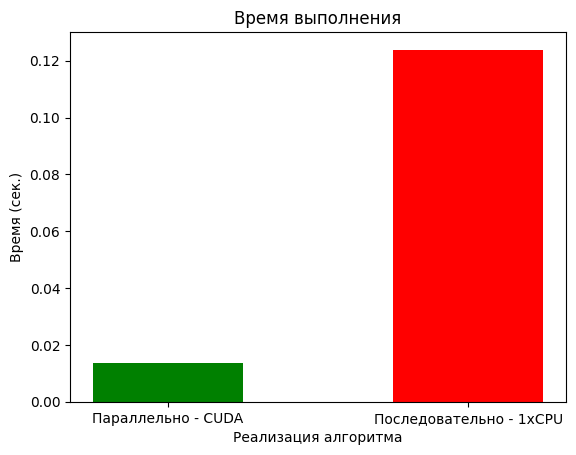

In [ ]:
import matplotlib.pyplot as plt


# Получаем время выполнения для обоих алгоритмов
serialExecutionTime = serial_execution_time(graph, 0)
cudaExecutionTime = CUDA_execution_time(graph, 0)
# Данные для теста используем одни и те же, поэтому размерности не будут отличаться
nodeCount = test_parallel_dijkstra_gpu(graph, 0)[0]
edgeCount = test_parallel_dijkstra_gpu(graph, 0)[1]
output_label = f"Алгоритмы получили одинковое количество узлов ({nodeCount}) и путей ({edgeCount}). \n" \
  f"Время выполнения последовательного алгоритма: {serialExecutionTime:.3f}сек. \n" \
  f"Время выполнения алгоритма с использованием CUDA: {cudaExecutionTime:.3f}сек. \n"
print(output_label)


# Формирование графиков
left = [1, 2]
# Высота графиков
height = [cudaExecutionTime, serialExecutionTime]
# Подписи к графиками
tick_label = ['Параллельно - CUDA', 'Последовательно - 1xCPU']
plt.bar(left, height, tick_label=tick_label,
        width=0.5, color=['green', 'red'])
plt.xlabel('Реализация алгоритма')
plt.ylabel('Время (сек.)')
plt.title('Время выполнения')
plt.show()

### Ответ на вопрос задачи

Ответ на поставленный вопрос сводится к сравнению полученных весов с заданным $q$, благодаря чему можно узнать существует ли путь с надежностью не меньшей чем $q$ для любых двух узлов подсети.

In [ ]:
q = 2# @param {type:"number"}

In [ ]:
for i in range(node_count):
  paths = parallel_dijkstra_gpu(graph, i)
  if np.all(paths < q):
    indexes = np.where(paths < q)
    print('Ответ: В сети существуют такие пути надежность между которыми меньше чем q')
    print('Например путь из вершины', i, 'в вершины:')
    print(str(*indexes))
    print('Надежности путей')
    print(paths)
    break
else:
  print('Ответ: Между каждыми двумя узлами сети есть хотя бы один путь с надежностью не меньше q')


Ответ: Между каждыми двумя узлами сети есть хотя бы один путь с надежностью не меньше q


Замечание: во время проверки при $q=2$ все пути удовлетворяли требованию по надежности, при $q=3$ уже находились такие пары вершин, между которыми не было ни одного пути с требуемой надежностью. При повторной генерации матрицы путей значения могут отличаться